In [ ]:
# ============================
# Imports and loading
# ============================
import os
import numpy as np
import trimesh
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.decomposition import KernelPCA
from sklearn.metrics import mean_squared_error


# ----------------------------
# Helper functions
# ----------------------------

def load_femurs(data_dir):
    """Load all femur .obj meshes and return list of vertex arrays + shared faces."""
    mesh_paths = sorted(
        [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".obj")]
    )
    print(f"Found {len(mesh_paths)} femur meshes")

    vertices_list = []
    faces_ref = None

    for path in mesh_paths:
        mesh = trimesh.load(path, process=False)
        V = np.asarray(mesh.vertices, dtype=np.float32)

        if faces_ref is None:
            faces_ref = mesh.faces
        else:
            # Vérification que les faces sont identiques (alignement déjà fait)
            if not np.array_equal(mesh.faces, faces_ref):
                raise ValueError(f"Mesh {path} has different topology — check alignment")

        vertices_list.append(V)

    return vertices_list, faces_ref


def flatten_vertices(vertices_list):
    """Flatten list of (n_vertices, 3) femurs → (n_samples, n_vertices*3)."""
    return np.stack([v.reshape(-1) for v in vertices_list])


def reconstruct_mesh(vertices_flat, faces):
    """Rebuild a trimesh.Trimesh from flattened vertices."""
    n_vertices = vertices_flat.shape[0] // 3
    vertices = vertices_flat.reshape(n_vertices, 3)
    return trimesh.Trimesh(vertices=vertices, faces=faces, process=False)


def plot_femur(vertices_flat, faces, title="Femur"):
    mesh = reconstruct_mesh(vertices_flat, faces)
    mesh.show()  # opens an interactive 3D viewer


# ----------------------------
# Load data
# ----------------------------

DATA_DIR = "./data"
vertices_list, faces = load_femurs(DATA_DIR)

# Flatten and center
X_flat = flatten_vertices(vertices_list)
scaler = StandardScaler(with_mean=True, with_std=False)
X_centered = scaler.fit_transform(X_flat)

print(f"Data shape: {X_centered.shape}")
print("Centered mean (first 10 dims):", np.round(X_centered.mean(axis=0)[:10], 5))


Found 24 femur meshes
Data shape: (24, 54873)
Centered mean (first 10 dims): [ 0.  0.  0.  0. -0. -0.  0.  0. -0. -0.]


The main challenge in KPCA is choosing an approriate kernel, here we choose a gaussian kernel...for the gamma hyperparameter we will do a "leave one out" split and choose it accordingly (this is done to avoid overfitting)

in the code bellow we fix the n_components to 23 and do a search grid on the logspace  (  [10- k..] )

gamma = 1.0e-10 | mean LOO MSE = 4.1649e+01
gamma = 3.8e-10 | mean LOO MSE = 4.1649e+01
gamma = 1.4e-09 | mean LOO MSE = 4.1649e+01
gamma = 5.5e-09 | mean LOO MSE = 4.1649e+01
gamma = 2.1e-08 | mean LOO MSE = 4.1649e+01
gamma = 7.8e-08 | mean LOO MSE = 4.1649e+01
gamma = 3.0e-07 | mean LOO MSE = 4.1649e+01
gamma = 1.1e-06 | mean LOO MSE = 4.1649e+01
gamma = 4.3e-06 | mean LOO MSE = 4.1649e+01
gamma = 1.6e-05 | mean LOO MSE = 4.1649e+01
gamma = 6.2e-05 | mean LOO MSE = 4.1649e+01
gamma = 2.3e-04 | mean LOO MSE = 4.1649e+01
gamma = 8.9e-04 | mean LOO MSE = 4.1649e+01
gamma = 3.4e-03 | mean LOO MSE = 4.1649e+01
gamma = 1.3e-02 | mean LOO MSE = 4.1649e+01
gamma = 4.8e-02 | mean LOO MSE = 4.1649e+01
gamma = 1.8e-01 | mean LOO MSE = 4.1649e+01
gamma = 7.0e-01 | mean LOO MSE = 4.1649e+01
gamma = 2.6e+00 | mean LOO MSE = 4.1649e+01
gamma = 1.0e+01 | mean LOO MSE = 4.1649e+01

Best gamma: 1.1288378916846883e-06


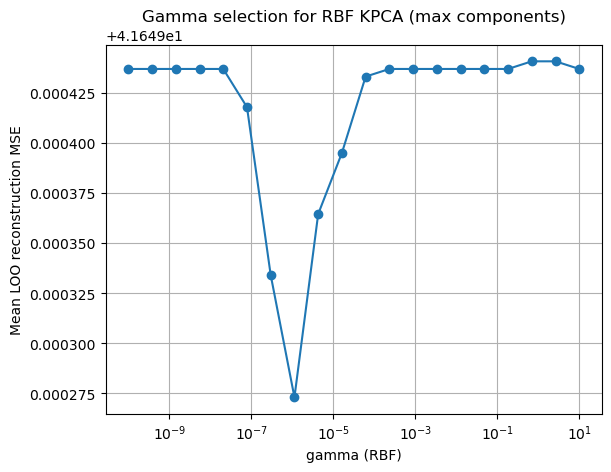

In [63]:
# ----------------------------
# Stage 1: tune gamma using LOO with max components
# ----------------------------

n_samples = X_centered.shape[0]
max_components = n_samples - 1  # 23 with LOO

# Log-spaced gamma grid (tune this depending on your scale)
gamma_list = np.logspace(-10, 1, 20)  # [1e-10, ..., 1e1]

loo = LeaveOneOut()

gamma_errors = []

for gamma in gamma_list:
    fold_errors = []

    for train_idx, test_idx in loo.split(X_flat):
        scaler_fold = StandardScaler(with_mean=True, with_std=False)
        X_train = scaler_fold.fit_transform(X_flat[train_idx])
        X_test  = scaler_fold.transform(X_flat[test_idx])

        kpca = KernelPCA(
            kernel="rbf",
            gamma=gamma,
            n_components=max_components,
            fit_inverse_transform=True
        )

        X_train_k = kpca.fit_transform(X_train)
        X_test_k = kpca.transform(X_test)

        X_test_recon_centered = kpca.inverse_transform(X_test_k)
        X_test_recon = scaler_fold.inverse_transform(X_test_recon_centered)

        err = mean_squared_error(X_test, X_test_recon_centered)
        fold_errors.append(err)

    mean_mse = np.mean(fold_errors)
    gamma_errors.append(mean_mse)
    print(f"gamma = {gamma:.1e} | mean LOO MSE = {mean_mse:.4e}")

# Pick best gamma
best_gamma_idx = int(np.argmin(gamma_errors))
best_gamma = gamma_list[best_gamma_idx]
print("\nBest gamma:", best_gamma)

# Plot error vs gamma
plt.figure()
plt.semilogx(gamma_list, gamma_errors, marker="o")
plt.xlabel("gamma (RBF)")
plt.ylabel("Mean LOO reconstruction MSE")
plt.title("Gamma selection for RBF KPCA (max components)")
plt.grid(True)
plt.show()


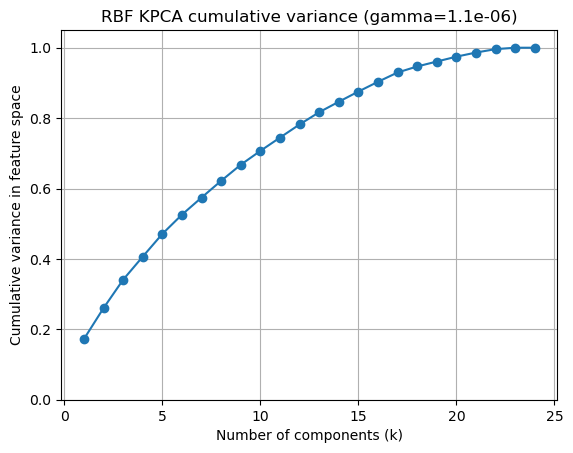

k= 1: cumulative variance ≈ 17.25%
k= 2: cumulative variance ≈ 26.04%
k= 3: cumulative variance ≈ 34.10%
k= 5: cumulative variance ≈ 47.11%
k=10: cumulative variance ≈ 70.69%
k=15: cumulative variance ≈ 87.55%
k=20: cumulative variance ≈ 97.46%


In [64]:
from sklearn.decomposition import KernelPCA
import numpy as np
import matplotlib.pyplot as plt

gamma = float(best_gamma)      # e.g. 1.1e-6
n_samples = X_centered.shape[0]

# Fit KPCA on ALL data with max number of components
kpca_full = KernelPCA(
    kernel="rbf",
    gamma=gamma,
    n_components=n_samples,    # at most n_samples comps
    fit_inverse_transform=False
)

X_k_full = kpca_full.fit_transform(X_centered)   # shape (24, n_components)

# --- Get "eigenvalues" / variances per component ---

# Option 1: if your version has eigenvalues_ or lambdas_, use them
if hasattr(kpca_full, "lambdas_"):
    eigvals = np.array(kpca_full.lambdas_)
elif hasattr(kpca_full, "eigenvalues_"):
    eigvals = np.array(kpca_full.eigenvalues_)
else:
    # Fallback: use variance of each component in feature space
    # (up to scaling this is equivalent to eigenvalues)
    eigvals = np.var(X_k_full, axis=0, ddof=1)

# Sort (normally already sorted, but just in case)
eigvals_sorted = np.sort(eigvals)[::-1]

# Normalized "explained variance ratio" in feature space
var_ratio = eigvals_sorted / eigvals_sorted.sum()
cum_var = np.cumsum(var_ratio)

ks = np.arange(1, len(eigvals_sorted) + 1)

plt.figure()
plt.plot(ks, cum_var, marker="o")
plt.xlabel("Number of components (k)")
plt.ylabel("Cumulative variance in feature space")
plt.title(f"RBF KPCA cumulative variance (gamma={gamma:.1e})")
plt.ylim(0, 1.05)
plt.grid(True)
plt.show()

for k in [1, 2, 3, 5, 10, 15, 20]:
    if k <= len(cum_var):
        print(f"k={k:2d}: cumulative variance ≈ {cum_var[k-1]*100:.2f}%")


In [65]:
# ----------------------------
# Reconstruct every femur with best (gamma, k)
# ----------------------------

best_k = 18  # ensure int

recon_centered = np.zeros_like(X_centered)
per_sample_mse = np.zeros(n_samples)

loo = LeaveOneOut()

for train_idx, test_idx in loo.split(X_flat):
    scaler_fold = StandardScaler(with_mean=True, with_std=False)
    X_train = scaler_fold.fit_transform(X_flat[train_idx])
    X_test  = scaler_fold.transform(X_flat[test_idx])

    kpca = KernelPCA(
        kernel="rbf",
        gamma=gamma,
        n_components=best_k,
        fit_inverse_transform=True,
    )

    X_train_k = kpca.fit_transform(X_train)
    X_test_k = kpca.transform(X_test)

    X_test_recon_centered = kpca.inverse_transform(X_test_k)
    X_test_recon = scaler_fold.inverse_transform(X_test_recon_centered)

    err = mean_squared_error(X_test, X_test_recon_centered)
    per_sample_mse[test_idx[0]] = err
    recon_centered[test_idx[0]] = X_test_recon[0]

print("Per-sample LOO MSEs:")
for i, e in enumerate(per_sample_mse):
    print(f"Femur {i:2d}: MSE = {e:.6f}")

# Undo centering to go back to original coordinates
X_recon_flat = scaler.inverse_transform(recon_centered)


Per-sample LOO MSEs:
Femur  0: MSE = 69.708374
Femur  1: MSE = 28.804167
Femur  2: MSE = 11.882176
Femur  3: MSE = 23.266705
Femur  4: MSE = 88.285553
Femur  5: MSE = 18.709202
Femur  6: MSE = 14.558478
Femur  7: MSE = 7.573619
Femur  8: MSE = 30.306412
Femur  9: MSE = 34.466095
Femur 10: MSE = 28.827803
Femur 11: MSE = 26.750278
Femur 12: MSE = 31.971348
Femur 13: MSE = 18.841719
Femur 14: MSE = 55.069023
Femur 15: MSE = 60.420303
Femur 16: MSE = 73.673492
Femur 17: MSE = 72.483696
Femur 18: MSE = 20.848131
Femur 19: MSE = 217.452682
Femur 20: MSE = 13.859216
Femur 21: MSE = 29.902071
Femur 22: MSE = 14.465049
Femur 23: MSE = 7.456975


In [89]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA

# =========================================================================
# 1. Configuration du Test Rigoureux (Leave-One-Out)
# =========================================================================
idx_test = 19  # Index du Fémur 19 (le pire cas original)
print(f"Test de généralisation sur le fémur #{idx_test} (exclu de l'entraînement)")

# Séparation des données : 23 pour Train, 1 pour Test
indices = np.arange(X_centered.shape[0])
train_mask = indices != idx_test

X_train_loo = X_centered[train_mask]   # (23, n_features)
X_test_full = X_centered[idx_test]     # (n_features,) Le fémur complet (Vérité Terrain)

# Récupération des hyperparamètres optimaux (depuis votre notebook)
gamma_best = 1.1288e-6 
n_components = 18

# =========================================================================
# 2. Entraînement du Modèle sur les 23 autres fémurs
# =========================================================================
print(f"Entraînement du KPCA sur {len(X_train_loo)} échantillons...")
kpca_loo = KernelPCA(
    n_components=n_components, 
    kernel="rbf", 
    gamma=gamma_best, 
    fit_inverse_transform=True,
    alpha=1.0 # Paramètre de régularisation pour l'inverse (ridge regression)
)
kpca_loo.fit(X_train_loo)

# =========================================================================
# 3. Simulation de la "Coupe" (Partie manquante)
# =========================================================================
# On travaille sur les coordonnées réelles pour la coupe géométrique
vertices_test_full = X_test_full.reshape(-1, 3) + scaler.mean_.reshape(-1, 3)
n_verts = vertices_test_full.shape[0]

# --- Mode: Garder la moitié inférieure ---
# Trouver l'axe principal (le plus long) pour couper
ranges = vertices_test_full.max(axis=0) - vertices_test_full.min(axis=0)
main_axis = np.argmax(ranges)
# Seuil
limit = np.percentile(vertices_test_full[:, main_axis], 30)

# Création du masque (True = on garde, False = on supprime)
keep_mask = vertices_test_full[:, main_axis] < limit
print(f"Conservation de {np.sum(keep_mask)} sommets sur {n_verts} (Moitié inférieure)")

# --- Préparation du vecteur d'entrée ---
# Pour projeter, on a besoin d'un vecteur de même taille que l'entraînement.
# On remplit les parties manquantes par 0 (la moyenne des données centrées).
X_input_partial = X_test_full.copy()
# Important: On met à 0 les coordonnées centrées correspondant aux points masqués
X_input_partial_reshaped = X_input_partial.reshape(-1, 3)
X_input_partial_reshaped[~keep_mask] = 0.0 
X_input_vector = X_input_partial_reshaped.flatten().reshape(1, -1)

# =========================================================================
# 4. Reconstruction via l'Espace Latent
# =========================================================================
# Projection (Encode)
X_latent = kpca_loo.transform(X_input_vector)
# Reconstruction (Decode)
X_recon = kpca_loo.inverse_transform(X_latent)[0]

# Remise à l'échelle pour visualisation (ajout de la moyenne)
vertices_recon = X_recon.reshape(-1, 3) + scaler.mean_.reshape(-1, 3)
vertices_input_visible = vertices_test_full[keep_mask] # Ce qu'on montre en rouge



# Calcul du score
mse_recon = np.mean((X_recon - X_test_full)**2)
print(f"MSE de Reconstruction (Généralisation) : {mse_recon:.4f}")

Test de généralisation sur le fémur #19 (exclu de l'entraînement)
Entraînement du KPCA sur 23 échantillons...
Conservation de 5487 sommets sur 18291 (Moitié inférieure)
MSE de Reconstruction (Généralisation) : 216.6983


In [90]:
# =========================================================================
# 5. Visualisation Interactive avec Trimesh
# =========================================================================
import trimesh

print("Préparation de la scène 3D...")

# A. Input Partiel (Nuage de points ROUGE)
# On utilise un PointCloud car il manque des sommets pour faire un maillage fermé
pc_input = trimesh.points.PointCloud(vertices_input_visible)
pc_input.colors = np.tile([255, 0, 0, 255], (len(vertices_input_visible), 1)) # Rouge opaque

# B. Reconstruction (Maillage VERT)
# On utilise les faces d'origine car la topologie ne change pas
mesh_recon = trimesh.Trimesh(vertices=vertices_recon, faces=faces, process=False)
mesh_recon.visual.vertex_colors = [0, 255, 0, 200] # Vert légèrement transparent

# C. Vérité Terrain (Maillage GRIS)
mesh_orig = trimesh.Trimesh(vertices=vertices_test_full, faces=faces, process=False)
mesh_orig.visual.vertex_colors = [200, 200, 200, 100] # Gris transparent

# Création de la scène avec translation pour éviter le chevauchement
# GAUCHE : Input (Ce qu'on a donné)
# CENTRE : Reconstruction (Ce que le modèle a imaginé)
# DROITE : Original (La réalité)
scene = trimesh.Scene([
    pc_input.apply_translation([0, 250, 0]), 
    mesh_recon,                               
    mesh_orig.apply_translation([0, 500, 0])  
])

print(f"MSE de Reconstruction (Généralisation) : {mse_recon:.4f}")
print("Affichage : Rouge=Input | Vert=Reconstruction | Gris=Original")
scene.show()

Préparation de la scène 3D...
MSE de Reconstruction (Généralisation) : 216.6983
Affichage : Rouge=Input | Vert=Reconstruction | Gris=Original


In [98]:
# =========================================================================
# 3. Simulation de Scénarios "Hardcore"
# =========================================================================

# CHOISISSEZ VOTRE CHALLENGE ICI :
# 'shaft_only'    = Garder uniquement le milieu (pas de tête, pas de genou)
# 'extreme_sparse'= Garder seulement 5% des points au hasard
CHALLENGE_MODE = 'shaft_only' 

print(f"--- MODE CHALLENGE : {CHALLENGE_MODE} ---")

vertices_test_full = X_test_full.reshape(-1, 3) + scaler.mean_.reshape(-1, 3)
n_verts = vertices_test_full.shape[0]
keep_mask = np.zeros(n_verts, dtype=bool)

if CHALLENGE_MODE == 'shaft_only':
    # On cherche l'axe principal (Z généralement)
    ranges = vertices_test_full.max(axis=0) - vertices_test_full.min(axis=0)
    main_axis = np.argmax(ranges)
    
    # On ne garde que ce qu'il y a entre 30% et 70% de la hauteur
    # C'est la partie la plus "cylindrique" et pauvre en information unique
    limit_low = np.percentile(vertices_test_full[:, main_axis], 40)
    limit_high = np.percentile(vertices_test_full[:, main_axis], 60)
    
    keep_mask = (vertices_test_full[:, main_axis] > limit_low) & \
                (vertices_test_full[:, main_axis] < limit_high)
    print("Test : Reconstruction des extrémités à partir du tube central.")

elif CHALLENGE_MODE == 'extreme_sparse':
    # On garde 5% des points aléatoirement
    ratio = 0.05 
    indices_keep = np.random.choice(n_verts, int(n_verts * ratio), replace=False)
    keep_mask[indices_keep] = True
    print(f"Test : Reconstruction à partir de {ratio*100}% de points épars.")

# --- Préparation de l'Input ---
X_input_partial = X_test_full.copy()
X_input_partial_reshaped = X_input_partial.reshape(-1, 3)

# IMPUTATION : On met à 0 (moyenne) tout ce qu'on ne connait pas
X_input_partial_reshaped[~keep_mask] = 0.0 
X_input_vector = X_input_partial_reshaped.flatten().reshape(1, -1)

# =========================================================================
# 4. Reconstruction & Visualisation (Code inchangé mais ré-exécuté)
# =========================================================================
X_latent = kpca_loo.transform(X_input_vector)
X_recon = kpca_loo.inverse_transform(X_latent)[0]

vertices_recon = X_recon.reshape(-1, 3) + scaler.mean_.reshape(-1, 3)
vertices_input_visible = vertices_test_full[keep_mask]

# Visualisation Trimesh
import trimesh
pc_input = trimesh.points.PointCloud(vertices_input_visible)
pc_input.colors = np.tile([255, 0, 0, 255], (len(vertices_input_visible), 1)) # ROUGE

mesh_recon = trimesh.Trimesh(vertices=vertices_recon, faces=faces, process=False)
mesh_recon.visual.vertex_colors = [0, 255, 0, 200] # VERT

mesh_orig = trimesh.Trimesh(vertices=vertices_test_full, faces=faces, process=False)
mesh_orig.visual.vertex_colors = [200, 200, 200, 100] # GRIS

mse_recon = np.mean((X_recon - X_test_full)**2)
print(f"MSE Résultat : {mse_recon:.4f}")

trimesh.Scene([
    pc_input.apply_translation([0, 250, 0]), 
    mesh_recon,                               
    mesh_orig.apply_translation([0, 500, 0])  
]).show()

--- MODE CHALLENGE : shaft_only ---
Test : Reconstruction des extrémités à partir du tube central.
MSE Résultat : 216.6980


In [99]:
# =========================================================================
# 3. Simulation de Scénarios "Hardcore"
# =========================================================================

# CHOISISSEZ VOTRE CHALLENGE ICI :
# 'shaft_only'    = Garder uniquement le milieu (pas de tête, pas de genou)
# 'extreme_sparse'= Garder seulement 5% des points au hasard
CHALLENGE_MODE = 'extreme_sparse' 

print(f"--- MODE CHALLENGE : {CHALLENGE_MODE} ---")

vertices_test_full = X_test_full.reshape(-1, 3) + scaler.mean_.reshape(-1, 3)
n_verts = vertices_test_full.shape[0]
keep_mask = np.zeros(n_verts, dtype=bool)

if CHALLENGE_MODE == 'shaft_only':
    # On cherche l'axe principal (Z généralement)
    ranges = vertices_test_full.max(axis=0) - vertices_test_full.min(axis=0)
    main_axis = np.argmax(ranges)
    
    # On ne garde que ce qu'il y a entre 30% et 70% de la hauteur
    # C'est la partie la plus "cylindrique" et pauvre en information unique
    limit_low = np.percentile(vertices_test_full[:, main_axis], 30)
    limit_high = np.percentile(vertices_test_full[:, main_axis], 70)
    
    keep_mask = (vertices_test_full[:, main_axis] > limit_low) & \
                (vertices_test_full[:, main_axis] < limit_high)
    print("Test : Reconstruction des extrémités à partir du tube central.")

elif CHALLENGE_MODE == 'extreme_sparse':
    # On garde 5% des points aléatoirement
    ratio = 0.05 
    indices_keep = np.random.choice(n_verts, int(n_verts * ratio), replace=False)
    keep_mask[indices_keep] = True
    print(f"Test : Reconstruction à partir de {ratio*100}% de points épars.")

# --- Préparation de l'Input ---
X_input_partial = X_test_full.copy()
X_input_partial_reshaped = X_input_partial.reshape(-1, 3)

# IMPUTATION : On met à 0 (moyenne) tout ce qu'on ne connait pas
X_input_partial_reshaped[~keep_mask] = 0.0 
X_input_vector = X_input_partial_reshaped.flatten().reshape(1, -1)

# =========================================================================
# 4. Reconstruction & Visualisation (Code inchangé mais ré-exécuté)
# =========================================================================
X_latent = kpca_loo.transform(X_input_vector)
X_recon = kpca_loo.inverse_transform(X_latent)[0]

vertices_recon = X_recon.reshape(-1, 3) + scaler.mean_.reshape(-1, 3)
vertices_input_visible = vertices_test_full[keep_mask]

# Visualisation Trimesh
import trimesh
pc_input = trimesh.points.PointCloud(vertices_input_visible)
pc_input.colors = np.tile([255, 0, 0, 255], (len(vertices_input_visible), 1)) # ROUGE

mesh_recon = trimesh.Trimesh(vertices=vertices_recon, faces=faces, process=False)
mesh_recon.visual.vertex_colors = [0, 255, 0, 200] # VERT

mesh_orig = trimesh.Trimesh(vertices=vertices_test_full, faces=faces, process=False)
mesh_orig.visual.vertex_colors = [200, 200, 200, 100] # GRIS

mse_recon = np.mean((X_recon - X_test_full)**2)
print(f"MSE Résultat : {mse_recon:.4f}")

trimesh.Scene([
    pc_input.apply_translation([0, 250, 0]), 
    mesh_recon,                               
    mesh_orig.apply_translation([0, 500, 0])  
]).show()

--- MODE CHALLENGE : extreme_sparse ---
Test : Reconstruction à partir de 5.0% de points épars.
MSE Résultat : 216.6980


In [102]:
# =========================================================================
# 3. Simulation de Scénarios "Hardcore"
# =========================================================================

# CHOISISSEZ VOTRE CHALLENGE ICI :
# 'shaft_only'    = Garder uniquement le milieu (pas de tête, pas de genou)
# 'extreme_sparse'= Garder seulement 5% des points au hasard
CHALLENGE_MODE = 'extreme_sparse' 

print(f"--- MODE CHALLENGE : {CHALLENGE_MODE} ---")

vertices_test_full = X_test_full.reshape(-1, 3) + scaler.mean_.reshape(-1, 3)
n_verts = vertices_test_full.shape[0]
keep_mask = np.zeros(n_verts, dtype=bool)

if CHALLENGE_MODE == 'shaft_only':
    # On cherche l'axe principal (Z généralement)
    ranges = vertices_test_full.max(axis=0) - vertices_test_full.min(axis=0)
    main_axis = np.argmax(ranges)
    
    # On ne garde que ce qu'il y a entre 30% et 70% de la hauteur
    # C'est la partie la plus "cylindrique" et pauvre en information unique
    limit_low = np.percentile(vertices_test_full[:, main_axis], 30)
    limit_high = np.percentile(vertices_test_full[:, main_axis], 70)
    
    keep_mask = (vertices_test_full[:, main_axis] > limit_low) & \
                (vertices_test_full[:, main_axis] < limit_high)
    print("Test : Reconstruction des extrémités à partir du tube central.")

elif CHALLENGE_MODE == 'extreme_sparse':
    # On garde 0% des points aléatoirement
    ratio = 0.0001
    indices_keep = np.random.choice(n_verts, int(n_verts * ratio), replace=False)
    keep_mask[indices_keep] = True
    print(f"Test : Reconstruction à partir de {ratio*100}% de points épars.")

# --- Préparation de l'Input ---
X_input_partial = X_test_full.copy()
X_input_partial_reshaped = X_input_partial.reshape(-1, 3)

# IMPUTATION : On met à 0 (moyenne) tout ce qu'on ne connait pas
X_input_partial_reshaped[~keep_mask] = 0.0 
X_input_vector = X_input_partial_reshaped.flatten().reshape(1, -1)

# =========================================================================
# 4. Reconstruction & Visualisation (Code inchangé mais ré-exécuté)
# =========================================================================
X_latent = kpca_loo.transform(X_input_vector)
X_recon = kpca_loo.inverse_transform(X_latent)[0]

vertices_recon = X_recon.reshape(-1, 3) + scaler.mean_.reshape(-1, 3)
vertices_input_visible = vertices_test_full[keep_mask]

# Visualisation Trimesh
import trimesh
pc_input = trimesh.points.PointCloud(vertices_input_visible)
pc_input.colors = np.tile([255, 0, 0, 255], (len(vertices_input_visible), 1)) # ROUGE

mesh_recon = trimesh.Trimesh(vertices=vertices_recon, faces=faces, process=False)
mesh_recon.visual.vertex_colors = [0, 255, 0, 200] # VERT

mesh_orig = trimesh.Trimesh(vertices=vertices_test_full, faces=faces, process=False)
mesh_orig.visual.vertex_colors = [200, 200, 200, 100] # GRIS

mse_recon = np.mean((X_recon - X_test_full)**2)
print(f"MSE Résultat : {mse_recon:.4f}")

trimesh.Scene([
    pc_input.apply_translation([-0, 250, 0]), 
    mesh_recon,                               
    mesh_orig.apply_translation([0, 500, 0])  
]).show()

--- MODE CHALLENGE : extreme_sparse ---
Test : Reconstruction à partir de 0.01% de points épars.
MSE Résultat : 216.6979


# 6. Analyse Critique et Limites : Le problème de l'Imputation par Zéro

Lors des tests précédents (notamment avec le mode `extreme_sparse` ou `shaft_only`), nous avons observé que le modèle produisait une forme de fémur plausible (MSE ~216) même avec très peu d'informations en entrée.

Le modèle KPCA avec un noyau RBF (Gaussien) ne "reconstruit" pas vraiment les données manquantes. Lorsqu'on remplace les valeurs inconnues par des zéros (imputation par la moyenne), le vecteur d'entrée devient géométriquement très éloigné de tous les échantillons d'entraînement.

**Mécanisme mathématique :**
Le noyau RBF est défini par : $k(x, y) = \exp(-\gamma ||x - y||^2)$.
Si l'entrée $x$ est majoritairement composée de zéros (données manquantes), la distance $||x - y||^2$ avec n'importe quel fémur d'entraînement $y$ devient immense.
Par conséquent, le noyau tend vers 0 : $\exp(-\text{grand nombre}) \approx 0$.

Le vecteur projeté dans l'espace latent s'effondre vers l'origine (0,0,...). Or, l'image inverse de l'origine dans l'espace des données correspond simplement à la **forme moyenne** du jeu de données.

on compare les deux reconstructions :
1. **Input Partiel :** Notre test avec 5% de données ou le tube seul.
2. **Input Vide :** Un vecteur constitué à 99.999% de zéros (preque aucune donnée).

les deux résultats sont identiques (ou presque), cela prouvera que le modèle ignore nos données partielles et renvoie simplement le "Fémur Moyen".